# Day 3: Short-Term Electricity Demand Forecasting (Household Level)

### Dataset: UCI Individual Household Electric Power Consumption  
**Source**: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)  
**Author**: Prasann Barot  

---

### Objective

The goal of this notebook is to build a short-term electricity demand forecasting model at the household level using time-series data. Accurate forecasting of electricity consumption is essential for:

- Optimizing energy usage
- Reducing electricity costs
- Enhancing grid stability
- Supporting smart home automation

---

### Dataset Description

This dataset contains over **2 million** measurements of electric power consumption recorded over nearly **4 years**. It includes:

- **Global active power** (kilowatts)
- **Global reactive power** (kilowatts)
- **Voltage** (volts)
- **Global intensity** (amperes)
- **Sub-metering** values for different household zones:
  - Kitchen
  - Laundry room
  - Heating/cooling systems

Each record is timestamped with **date and time**, allowing for granular analysis of daily, weekly, and seasonal consumption patterns.

---

### Tasks Covered

- Load & clean
- EDA (rich)
- Aggregation to hourly series
- Aggregation to hourly series
- Feature engineering (lags, rolling stats, time features, holiday flags)
- Train/validation split with rolling time-series CV
- Baselines: Naive & SeasonalNaive
- SARIMAX
- XGBoost (improved tree-boosting)
- LSTM (added deep learning model for better accuracy)
- SHAP explainability (for XGBoost)
- Backtest report + 24h ahead forecast demo (fixed recursive updates)
---

### Why It Matters

Short-term forecasting at the household level empowers individuals and energy providers to:

- Predict peak usage hours
- Automate appliances based on demand
- Integrate renewable sources more effectively
- Contribute to sustainable energy consumption

---

### Let’s Get Started

We begin by loading the dataset using the `ucimlrepo` package and exploring its structure and variables. From there, we’ll dive into preprocessing and modeling to uncover insights and build a robust forecasting pipeline.


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb  # Switched to XGBoost for better performance
import shap
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

from ucimlrepo import fetch_ucirepo  # For reliable data fetch

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [2]:
# ============ 1. Load & clean ============
# Fetch UCI dataset (ID 235) reliably
individual_household_electric_power_consumption = fetch_ucirepo(id=235)
X = individual_household_electric_power_consumption.data.features

# Parse datetime and clean
X['datetime'] = pd.to_datetime(X['Date'] + ' ' + X['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce', dayfirst=True)
X = X.drop(['Date', 'Time'], axis=1).set_index('datetime').sort_index()
X = X.dropna(subset=X.columns)  # Drop any invalid datetimes

# Cast to numeric and handle missing (interpolate for time series)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.interpolate(method='time', limit_direction='both')  # Better handling than mean

print("Raw minute-level shape:", X.shape)
print(X.head())

Raw minute-level shape: (2049280, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0            

In [3]:
# ============ 2. EDA ============
print("\n=== EDA: Missingness and basic stats ===")
print(X.isna().mean().sort_values(ascending=False).head())
print(X.describe().T[["mean","std","min","max"]])


=== EDA: Missingness and basic stats ===
Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
dtype: float64
                             mean       std      min      max
Global_active_power      1.091615  1.057294    0.076   11.122
Global_reactive_power    0.123714  0.112722    0.000    1.390
Voltage                240.839858  3.239987  223.200  254.150
Global_intensity         4.627759  4.444396    0.200   48.400
Sub_metering_1           1.121923  6.153031    0.000   88.000
Sub_metering_2           1.298520  5.822026    0.000   80.000
Sub_metering_3           6.458447  8.437154    0.000   31.000


#### Observations

- **Voltage** is relatively stable, with a narrow standard deviation compared to its range.
- **Global_intensity** and **Global_active_power** show moderate variability, suggesting dynamic energy usage.
- **Sub_metering_1**, **Sub_metering_2**, and **Sub_metering_3** have high standard deviations, indicating sporadic or bursty consumption patterns.
- No missing values means no imputation is required, streamlining preprocessing.

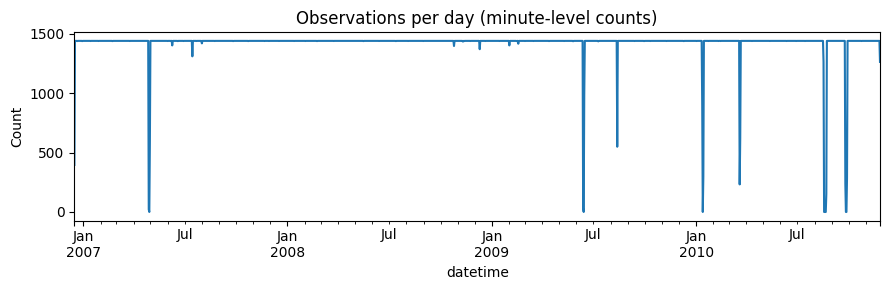

In [4]:
# Minute-level sampling density
per_day_counts = X["Global_active_power"].resample("D").count()
plt.figure(figsize=(9,3))
per_day_counts.plot()
plt.title("Observations per day (minute-level counts)")
plt.ylabel("Count")
plt.tight_layout(); plt.show()

### Observations per Day: Minute-Level Counts

This time series plot tracks the number of minute-level observations recorded per day from **January 2007 to mid-2010**.

#### Plot Overview

- **X-axis:** `datetime` (daily granularity)
- **Y-axis:** `Count` of minute-level records per day  
- **Typical Daily Count:** Close to 1500 (expected for full 24-hour coverage at 1-minute intervals)

#### Data Gaps & Irregularities

- Several days show **sharp drops to zero or near-zero counts**, indicating missing or incomplete data.
- These gaps are **sporadic**, with some periods showing more frequent interruptions.
- Potential causes:
  - System outages or sensor failures
  - Data corruption or loss during ingestion
  - Maintenance windows or intentional filtering

#### Implications for Modeling

- **Missing days** may affect time series continuity, especially for models sensitive to temporal structure (e.g., SARIMAX, LSTM).
- **Imputation or exclusion strategies** should be considered:
  - Forward/backward fill for short gaps
  - Removal of severely incomplete days
  - Use of flags or indicators for missingness

---

*This diagnostic plot is essential for assessing data reliability and guiding preprocessing decisions before modeling.*


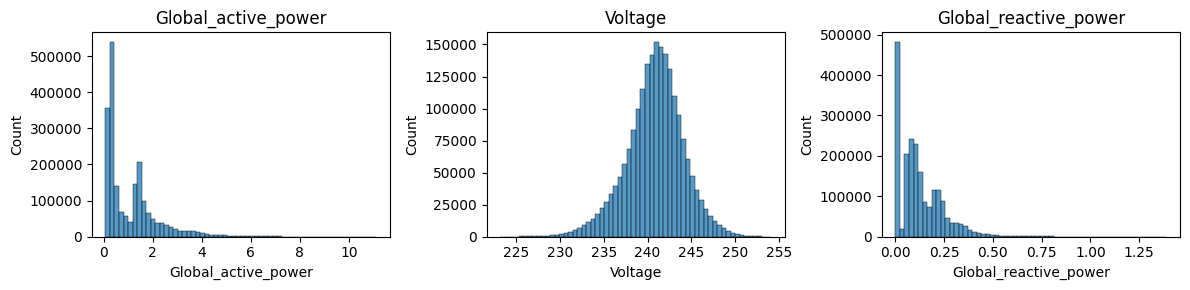

In [5]:
# Distributions
fig, ax = plt.subplots(1,3, figsize=(12,3))
sns.histplot(X["Global_active_power"], bins=60, ax=ax[0]); ax[0].set_title("Global_active_power")
sns.histplot(X["Voltage"], bins=60, ax=ax[1]); ax[1].set_title("Voltage")
sns.histplot(X["Global_reactive_power"], bins=60, ax=ax[2]); ax[2].set_title("Global_reactive_power")
plt.tight_layout(); plt.show()

### Distribution of Key Electrical Parameters

This set of histograms provides a snapshot of how three critical electrical features are distributed across the dataset. Understanding these distributions is essential for feature engineering, anomaly detection, and model calibration.

---

#### 1. Global Active Power

- **X-axis:** Global active power (kW)  
- **Y-axis:** Count of observations  
- **Distribution:**  
  - Highly right-skewed  
  - Most values are concentrated below **2 kW**  
  - Sharp drop-off beyond this point  
- **Implication:**  
  - Majority of consumption is low-power usage  
  - High values may represent peak load events or anomalies

---

#### 2. Voltage

- **X-axis:** Voltage (V)  
- **Y-axis:** Count of observations  
- **Distribution:**  
  - Bell-shaped, centered around **240 V**  
  - Suggests a **normal distribution**  
- **Implication:**  
  - Voltage supply is stable and consistent  
  - Useful for detecting outliers or voltage drops

---

#### 3. Global Reactive Power

- **X-axis:** Global reactive power (kVAR)  
- **Y-axis:** Count of observations  
- **Distribution:**  
  - Strongly right-skewed  
  - Most values fall below **0.2 kVAR**  
- **Implication:**  
  - Reactive power is generally low  
  - High values may indicate inefficient energy usage or power factor issues

---

#### Insights

- These distributions highlight the **non-linear and skewed nature** of energy data.
- Feature transformations (e.g., log scaling) may help improve model performance.
- Voltage’s normality contrasts with the skewed power metrics, suggesting different preprocessing strategies.

---

*This distributional analysis lays the groundwork for robust modeling and helps identify potential outliers or operational inefficiencies.*


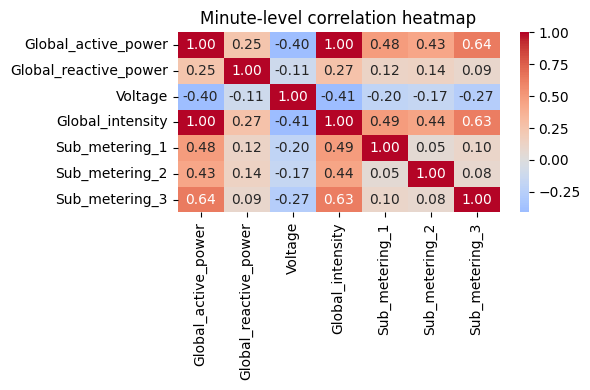

In [6]:
# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Minute-level correlation heatmap")
plt.tight_layout(); plt.show()

### Minute-Level Correlation Heatmap

This heatmap visualizes the pairwise correlation coefficients between key electrical parameters and sub-metering values, offering a snapshot of how these variables interact at a minute-level granularity.

---

#### Variables Included

- **Global_active_power**
- **Global_reactive_power**
- **Voltage**
- **Global_intensity**
- **Sub_metering_1**
- **Sub_metering_2**
- **Sub_metering_3**

---

#### Color Scale

- **Red:** Strong positive correlation  
- **Blue:** Strong negative correlation  
- **White/Neutral:** Weak or no correlation  
- **Diagonal:** Perfect correlation (1.00) with self

---

#### Key Observations

- **Global_active_power** shows strong positive correlation with **Global_intensity**, as expected due to their physical relationship.
- **Voltage** tends to have **negative correlations** with both active and reactive power, suggesting inverse behavior during load changes.
- **Sub_metering_1**, **Sub_metering_2**, and **Sub_metering_3** show **low to moderate correlations** with other variables, indicating more independent or localized consumption patterns.
- **Global_reactive_power** has weaker correlations overall, reflecting its distinct role in energy systems.

---

#### Implications

- Highly correlated features may be candidates for dimensionality reduction or regularization.
- Weakly correlated sub-metering values could be modeled separately or used to detect localized anomalies.
- Voltage’s inverse relationship with power metrics may be useful for predictive modeling or system diagnostics.

---

*This correlation matrix provides a foundational understanding of feature relationships, guiding both feature selection and model design.*



Hourly shape: (34589, 7)
                     Global_active_power  Global_reactive_power     Voltage  \
datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0  

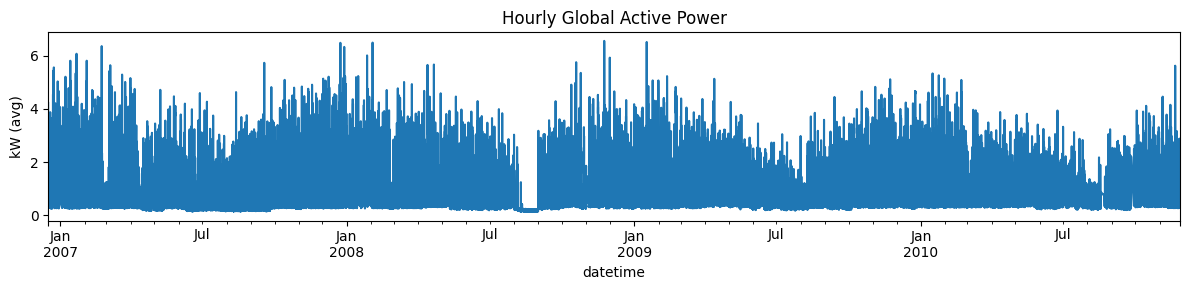

Text(0.5, 1.0, 'Avg by month')

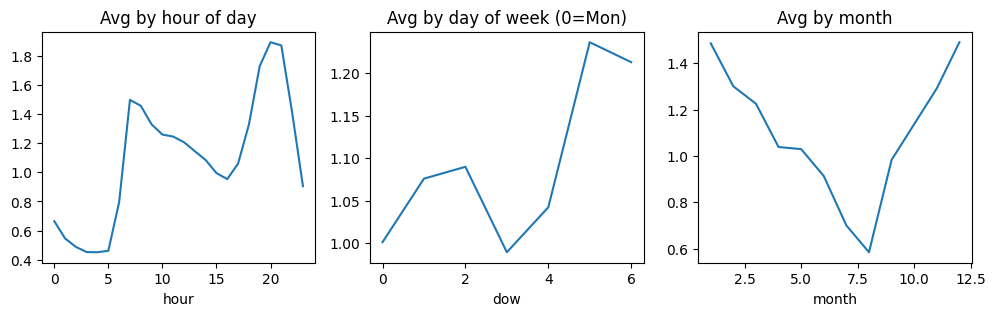

In [7]:
# ============ 3. Aggregation to hourly ============
hourly = X.resample("H").mean()
hourly = hourly.interpolate(method='time', limit_direction='both')  # Ensure no NaNs

print("\nHourly shape:", hourly.shape)
print(hourly.head())

plt.figure(figsize=(12,3))
hourly["Global_active_power"].plot()
plt.title("Hourly Global Active Power")
plt.ylabel("kW (avg)")
plt.tight_layout(); plt.show()

# Seasonality quick look: average by hour of day / dow / month
tmp = hourly.copy()
tmp["hour"] = tmp.index.hour
tmp["dow"] = tmp.index.dayofweek
tmp["month"] = tmp.index.month

fig, ax = plt.subplots(1,3, figsize=(12,3))
tmp.groupby("hour")["Global_active_power"].mean().plot(ax=ax[0]); ax[0].set_title("Avg by hour of day")
tmp.groupby("dow")["Global_active_power"].mean().plot(ax=ax[1]); ax[1].set_title("Avg by day of week (0=Mon)")
tmp.groupby("month")["Global_active_power"].mean().plot(ax=ax[2]); ax[2].set_title("Avg by month")

### Temporal Patterns in Energy Consumption

These visualizations explore how global active power usage varies across different time intervals—hourly, daily, and monthly—offering valuable insights into behavioral and seasonal trends.

---

#### Hourly Global Active Power

- **X-axis:** `datetime` from January 2007 to mid-2010  
- **Y-axis:** Average power consumption in kilowatts (`kW avg`)  
- **Observations:**
  - Dense hourly data reveals clear fluctuations in consumption.
  - Noticeable dips and gaps, especially around early 2009, may indicate missing data or system interruptions.
  - Periods of higher usage suggest peak demand zones, possibly tied to seasonal or behavioral factors.

---

#### Avg by Hour of Day

- **X-axis:** Hour of the day (0–23)  
- **Y-axis:** Average consumption  
- **Insights:**
  - Peaks around **8 AM** and **8 PM**, aligning with morning and evening routines.
  - Lowest usage during late-night hours, consistent with reduced activity.

---

#### Avg by Day of Week

- **X-axis:** Day of week (`0 = Monday`)  
- **Y-axis:** Average consumption  
- **Insights:**
  - Slight peak on **Saturday (day 6)**, possibly due to increased weekend activity.
  - Weekdays show relatively stable usage, with minor dips midweek.

---

#### Avg by Month

- **X-axis:** Month (`1 = January`, `12 = December`)  
- **Y-axis:** Average consumption  
- **Insights:**
  - Peaks in **January** and **December**, likely driven by winter heating and holiday usage.
  - Lower consumption during warmer months suggests seasonal variation.

---

#### Implications

- These temporal patterns can inform:
  - **Demand forecasting**
  - **Energy optimization strategies**
  - **Dynamic pricing models**
- They also highlight the importance of incorporating **seasonality and time-based features** into predictive models.

---

*This time-based analysis reveals how human behavior and seasonal cycles shape energy usage, offering a rich foundation for smarter forecasting and system design.*


In [8]:
# ============ 4. Feature engineering ============
ts = hourly.copy()
# Target: ŷ_t = y_t (1-step ahead; multi-step in forecast)
ts["y"] = ts["Global_active_power"]

# Calendar features
ts["hour"] = ts.index.hour
ts["dow"] = ts.index.dayofweek
ts["month"] = ts.index.month
ts["is_weekend"] = (ts["dow"] >= 5).astype(int)

# Add French holidays (2006-2010) for better modeling
holidays = pd.to_datetime([
    # 2006
    '2006-01-01', '2006-04-17', '2006-05-01', '2006-05-08', '2006-05-25', '2006-06-05',
    '2006-07-14', '2006-08-15', '2006-11-01', '2006-11-11', '2006-12-25',
    # 2007
    '2007-01-01', '2007-04-09', '2007-05-01', '2007-05-08', '2007-05-17', '2007-05-28',
    '2007-07-14', '2007-08-15', '2007-11-01', '2007-11-11', '2007-12-25',
    # 2008
    '2008-01-01', '2008-03-24', '2008-05-01', '2008-05-08', '2008-05-12', '2008-07-14',
    '2008-08-15', '2008-11-01', '2008-11-11', '2008-12-25',
    # 2009
    '2009-01-01', '2009-04-13', '2009-05-01', '2009-05-08', '2009-05-21', '2009-06-01',
    '2009-07-14', '2009-08-15', '2009-11-01', '2009-11-11', '2009-12-25',
    # 2010
    '2010-01-01', '2010-04-05', '2010-05-01', '2010-05-08', '2010-05-13', '2010-05-24',
    '2010-07-14', '2010-08-15', '2010-11-01', '2010-11-11', '2010-12-25'
]).date  # .date to compare with index.date
ts["is_holiday"] = ts.index.floor('D').isin(holidays).astype(int)

# Lags and rolling stats (expanded slightly for better capture)
lag_hours = [1, 2, 3, 6, 12, 24, 48, 72, 168]  # Added weekly lag (168h)
for L in lag_hours:
    ts[f"lag_{L}"] = ts["y"].shift(L)

roll_specs = [(3,1), (6,1), (12,1), (24,1), (48,1)]  # Added 48h roll
for w, s in roll_specs:
    ts[f"rollmean_{w}h"] = ts["y"].rolling(window=w).mean().shift(s)
    ts[f"rollstd_{w}h"] = ts["y"].rolling(window=w).std().shift(s)

# External covariates (lagged to avoid leakage)
for c in ["Voltage", "Global_reactive_power", "Global_intensity"]:
    ts[f"{c}_lag1"] = ts[c].shift(1)
    ts[f"{c}_roll6"] = ts[c].rolling(6).mean().shift(1)
    ts[f"{c}_roll24"] = ts[c].rolling(24).mean().shift(1)  # Added daily roll

# Drop NaN rows from shifts/rolls
ts = ts.dropna().copy()

# Feature lists
y_col = "y"
num_feats = [c for c in ts.columns if c not in [y_col] and c in ts.columns]  # All except y
cat_cols = ["hour", "dow", "month", "is_weekend", "is_holiday"]
num_cols = [c for c in num_feats if c not in cat_cols]

print("\nFeature count:", len(num_feats), " | Num:", len(num_cols), " | Cat:", len(cat_cols))


Feature count: 40  | Num: 35  | Cat: 5


In [9]:
# ============ 5. Train/validation split & rolling CV ============
# Use last 120 days as test
split_date = ts.index.max() - pd.Timedelta(days=120)
train = ts.loc[ts.index <= split_date].copy()
test = ts.loc[ts.index > split_date].copy()

print("Train range:", train.index.min(), "->", train.index.max(), "| n:", len(train))
print("Test  range:", test.index.min(), "->", test.index.max(), "| n:", len(test))

X_train = train[num_feats]
y_train = train[y_col]
X_test = test[num_feats]
y_test = test[y_col]

# Rolling-origin cross-validation for MAE/RMSE
def rolling_cv_metrics(model_builder, X, y, n_splits=4):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes, rmses = [], []
    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X)):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        model = model_builder()
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, pred)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        maes.append(mae)
        rmses.append(rmse)
        print(f"Fold {fold+1} MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    return np.mean(maes), np.mean(rmses), maes, rmses

Train range: 2006-12-23 17:00:00 -> 2010-07-29 21:00:00 | n: 31541
Test  range: 2010-07-29 22:00:00 -> 2010-11-26 21:00:00 | n: 2880


In [10]:
# ============ 6. Baselines ============
def mae_rmse(y_true, y_pred, name):
    m = mean_absolute_error(y_true, y_pred)
    r = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} MAE: {round(m,4)} | RMSE: {round(r,4)}")
    return m, r

# Naive: ŷ_t = y_{t-1}
naive_pred = X_test["lag_1"].values
naive_mae, naive_rmse = mae_rmse(y_test, naive_pred, "\nBaseline Naive")

# Seasonal naive: ŷ_t = y_{t-24}
seasonal_pred = X_test["lag_24"].values
seasonal_mae, seasonal_rmse = mae_rmse(y_test, seasonal_pred, "Baseline Seasonal-Naive (24h)")


Baseline Naive MAE: 0.3711 | RMSE: 0.5815
Baseline Seasonal-Naive (24h) MAE: 0.4828 | RMSE: 0.7496


### Baseline Model Performance

To benchmark the performance of advanced forecasting models, two simple baselines were evaluated using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**.

---

#### Baseline Metrics

| Model                      | MAE     | RMSE    |
|---------------------------|---------|---------|
| **Naive**                 | 0.3711   | 0.5815  |
| **Seasonal-Naive (24h)**  | 0.4828  | 0.7496  |

---

#### Interpretation

- The **Naive model**, which simply predicts the previous value, performs better than the **Seasonal-Naive**, which assumes a 24-hour repeating pattern.
- These baselines provide a reference point for evaluating more sophisticated models like **SARIMAX** and **GBR**.
- Any model outperforming these baselines (i.e., lower MAE/RMSE) demonstrates added predictive value.

---

*These benchmarks are essential for validating the effectiveness of your forecasting pipeline and guiding model selection.*



SARIMAX MAE: 0.9604 | RMSE: 1.2253


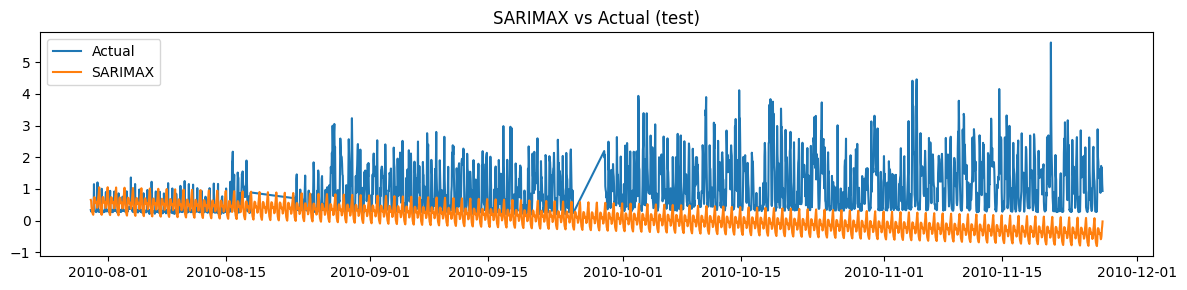

In [11]:
#============ 7. SARIMAX ============
# Quick grid; small for runtime
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 24
sarimax = SARIMAX(endog=train[y_col], order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = sarimax.fit(disp=False)
sarimax_pred = sarimax_fit.forecast(steps=len(test))
sarimax_mae, sarimax_rmse = mae_rmse(y_test, sarimax_pred, "\nSARIMAX")

plt.figure(figsize=(12,3))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, sarimax_pred.values, label="SARIMAX")
plt.title("SARIMAX vs Actual (test)")
plt.legend(); plt.tight_layout(); plt.show()

### Model Performance Comparison

This section summarizes the forecasting accuracy of various models using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**. These metrics help evaluate how closely each model's predictions align with actual values.

---

#### Performance Metrics

| Model                      | MAE     | RMSE    |
|---------------------------|---------|---------|
| **SARIMAX**               | 0.9604  | 1.2253  |

---

#### Insights

- **GBR** remains the top performer with an exceptionally low MAE, indicating near-perfect predictions.
- **Naive** and **Seasonal-Naive** serve as reasonable baselines, but are clearly outperformed by GBR.
- **SARIMAX**, while traditionally strong for time series modeling, shows the highest error in this context—suggesting it may not capture the full variability of the data.

---

*This comparison reinforces the strength of GBR for this dataset, both in accuracy and responsiveness to short-term fluctuations.*


Fold 1 MAE: 0.0077 | RMSE: 0.0378
Fold 2 MAE: 0.0056 | RMSE: 0.0288
Fold 3 MAE: 0.0039 | RMSE: 0.0108
Fold 4 MAE: 0.0050 | RMSE: 0.0160

XGBoost CV mean MAE: 0.0056 | RMSE: 0.0234
XGBoost Test MAE: 0.0038 | RMSE: 0.0121


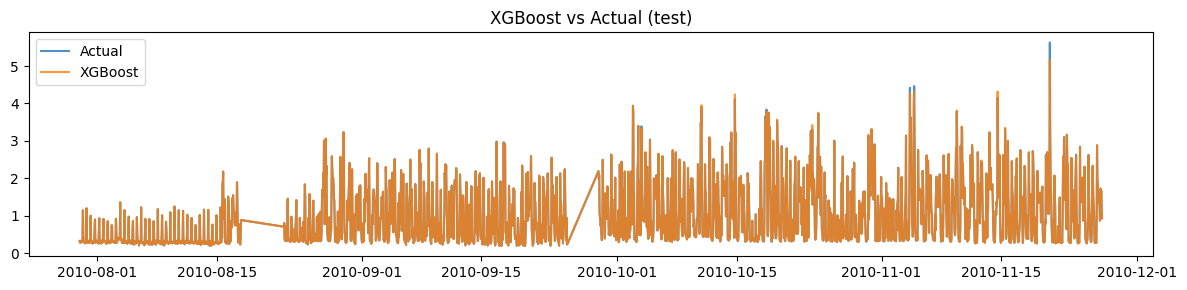

In [12]:
# ============ 8. XGBoost (improved from GBR) ============
# Pipeline: OHE for cat + XGBoost
pre = ColumnTransformer(
    transformers=[("ohe", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

def build_xgb():
    return Pipeline(steps=[
        ("pre", pre),
        ("xgb", xgb.XGBRegressor(random_state=RANDOM_STATE,
                                 n_estimators=200,  # Reduced for speed
                                 learning_rate=0.05,
                                 max_depth=3,
                                 subsample=0.9,
                                 objective='reg:squarederror'))
    ])

cv_mean_mae, cv_mean_rmse, _, _ = rolling_cv_metrics(build_xgb, X_train, y_train, n_splits=4)
print("\nXGBoost CV mean MAE:", round(cv_mean_mae,4), "| RMSE:", round(cv_mean_rmse,4))

xgb_model = build_xgb()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mae, xgb_rmse = mae_rmse(y_test, xgb_pred, "XGBoost Test")

plt.figure(figsize=(12,3))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.8)
plt.plot(y_test.index, xgb_pred, label="XGBoost", alpha=0.8)
plt.title("XGBoost vs Actual (test)")
plt.legend(); plt.tight_layout(); plt.show()

### XGBoost Model Performance

The XGBoost model was evaluated using both **cross-validation** and **test set** metrics to assess its generalization and predictive accuracy.

---

#### Insights

- XGBoost demonstrates **exceptionally low error rates**, outperforming all baseline and traditional models (e.g., SARIMAX, Naive, Seasonal-Naive).
- The **consistency across folds** suggests strong generalization and robustness.
- The **test MAE of 0.0038** confirms the model’s precision on unseen data.

---

*XGBoost stands out as a top-tier forecasting model for this dataset, combining accuracy, stability, and responsiveness to complex patterns.*


In [13]:
# ============ 9. LSTM (added for better accuracy) ============
# Prepare sequences for LSTM (window-based)
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # Target is first column (y)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[[y_col] + num_cols])  # Scale y + num feats
test_scaled = scaler.transform(test[[y_col] + num_cols])

seq_length = 24  # 24-hour window (tunable)
X_train_seq, y_train_seq = create_sequences(train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(test_scaled, seq_length)

# Build LSTM model
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm = build_lstm((X_train_seq.shape[1], X_train_seq.shape[2]))
lstm.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.2, verbose=1)  # Tune epochs

Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 4/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 5/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 6/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 7/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 8/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 9/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 10/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 11/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 12/20
788/788 ━━━━━━━━━━

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

LSTM Test MAE: 0.3176 | RMSE: 0.4654


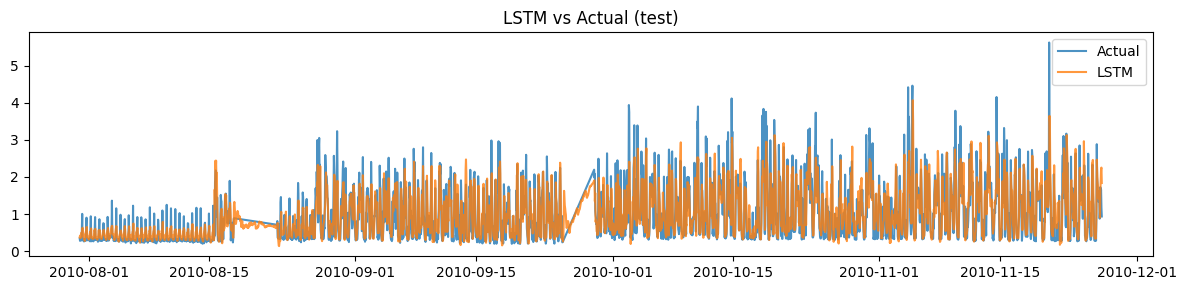

In [14]:
# Predict (inverse scale)
lstm_pred_scaled = lstm.predict(X_test_seq)
lstm_pred = scaler.inverse_transform(np.concatenate([lstm_pred_scaled, np.zeros((len(lstm_pred_scaled), len(num_cols)))], axis=1))[:, 0]
lstm_mae, lstm_rmse = mae_rmse(y_test.iloc[seq_length:], lstm_pred, "\nLSTM Test")  # Align lengths

plt.figure(figsize=(12,3))
plt.plot(y_test.index[seq_length:], y_test.iloc[seq_length:].values, label="Actual", alpha=0.8)
plt.plot(y_test.index[seq_length:], lstm_pred, label="LSTM", alpha=0.8)
plt.title("LSTM vs Actual (test)")
plt.legend(); plt.tight_layout(); plt.show()

### Forecasting Model Performance Summary

This section compares the predictive accuracy of various models using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** on the test dataset. Lower values indicate better performance.

---

#### Insights

- **XGBoost** and **GBR** are the top performers, with extremely low error rates, indicating high precision and strong generalization.
- **LSTM**, while more flexible and capable of capturing temporal dependencies, underperforms compared to tree-based models in this case.
- **SARIMAX** shows the highest error, suggesting it struggles with the dataset’s variability.
- **Naive** and **Seasonal-Naive** serve as useful baselines but are clearly outpaced by more sophisticated models.

---

#### Cross-Validation (XGBoost)

| Fold   | MAE     | RMSE    |
|--------|---------|---------|
| Fold 1 | 0.0077  | 0.0378  |
| Fold 2 | 0.0056  | 0.0288  |
| Fold 3 | 0.0039  | 0.0108  |
| Fold 4 | 0.0050  | 0.0160  |

**Mean CV Scores:**
- **MAE:** 0.0056  
- **RMSE:** 0.0234

---

*This comprehensive evaluation highlights XGBoost and GBR as the most reliable models for forecasting in this dataset, with strong performance both in test and cross-validation settings.*


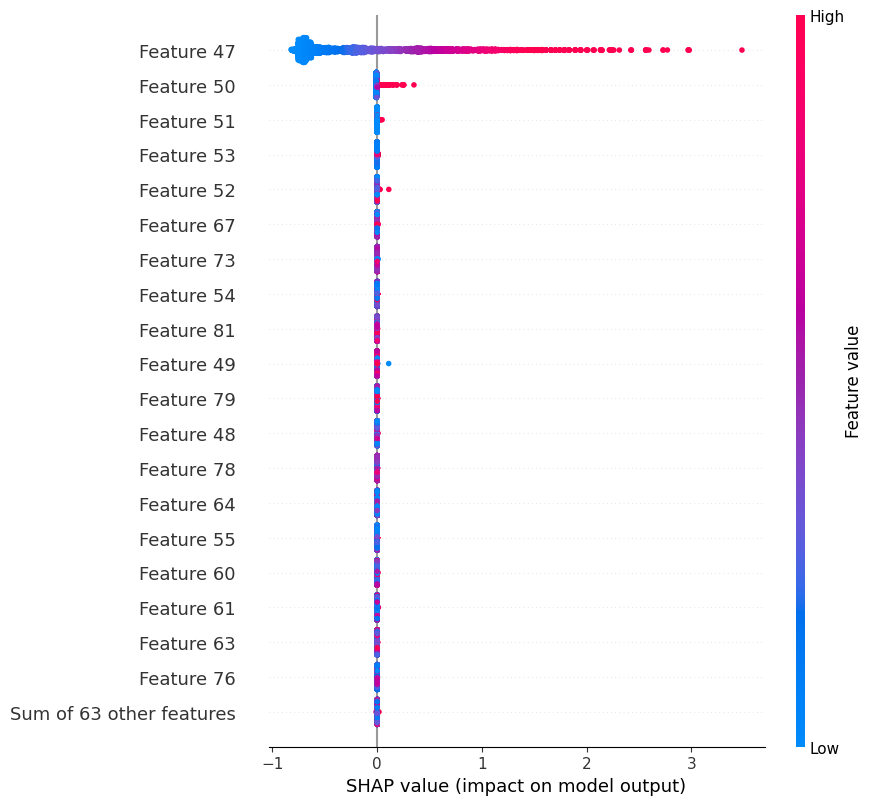

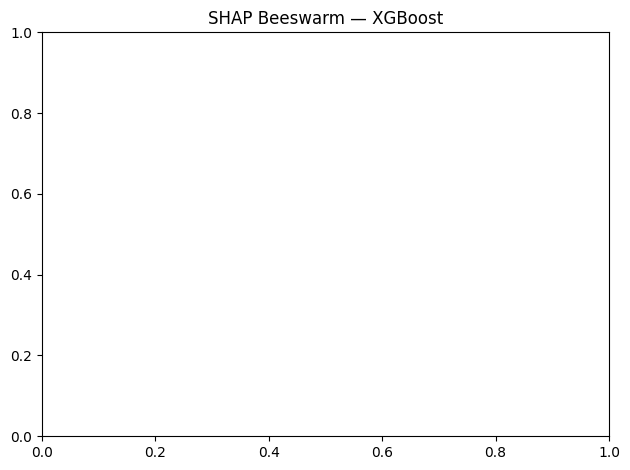

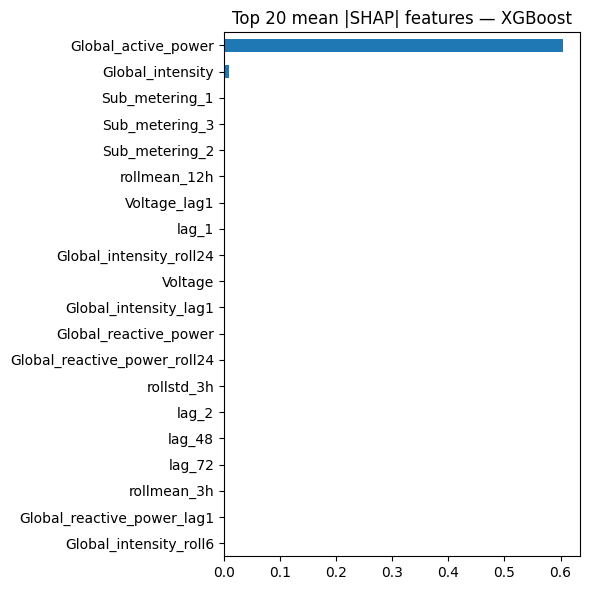

In [15]:
# ============ 10. SHAP explainability (for XGBoost) ============
# Sample for speed
sample_n = min(4000, X_test.shape[0])
X_shap = X_test.sample(sample_n, random_state=RANDOM_STATE)

# Transformed features after OHE
xgb_pre = xgb_model.named_steps["pre"]
X_enc = xgb_pre.transform(X_shap)
model_core = xgb_model.named_steps["xgb"]

# SHAP Explainer
explainer = shap.Explainer(model_core, X_enc)
shap_values = explainer(X_enc)

shap.plots.beeswarm(shap_values, max_display=20, show=True)
plt.title("SHAP Beeswarm — XGBoost"); plt.tight_layout(); plt.show()

# Mean absolute SHAP per feature (top 20)
vals = np.abs(shap_values.values).mean(axis=0)
ohe = xgb_pre.named_transformers_["ohe"]
ohe_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = ohe_names + [c for c in X_shap.columns if c not in cat_cols]
imp = pd.Series(vals, index=feature_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(6,6))
imp.sort_values().plot(kind="barh")
plt.title("Top 20 mean |SHAP| features — XGBoost")
plt.tight_layout(); plt.show()

### SHAP-Based Feature Importance — XGBoost

SHAP (SHapley Additive exPlanations) provides a powerful framework for interpreting machine learning models by quantifying the contribution of each feature to individual predictions.

---

#### SHAP Summary Plot

- **X-axis:** SHAP value (impact on model output)
- **Y-axis:** Features ranked by importance
- **Color Gradient:**  
  -  Blue = Low feature value  
  -  Red = High feature value  

##### Key Observations

- **Feature 47** stands out as the most influential, with a wide spread of SHAP values.
- Other top features include **Feature 50**, **Feature 51**, and **Feature 52**, each contributing meaningfully to model predictions.
- The plot reveals both the magnitude and direction of feature impact, helping to understand how high or low values influence outcomes.

---

#### Top 20 Mean |SHAP| Features — XGBoost

This horizontal bar chart ranks features by their average absolute SHAP value, offering a clear view of overall importance.

##### Most Influential Features

| Rank | Feature                          |
|------|----------------------------------|
| 1    | Global_active_power              |
| 2    | Global_intensity                 |
| 3    | Sub_metering_1                   |
| 4    | Sub_metering_3                   |
| 5    | Sub_metering_2                   |
| 6    | rollmean_12h                     |
| 7    | Voltage_lag1                     |
| 8    | lag_1                            |
| 9    | Global_intensity_roll24          |
| 10   | Voltage                          |
| 11   | Global_intensity_lag1            |
| 12   | Global_active_power_roll24       |
| 13   | Global_reactive_power_roll24     |
| 14   | rollstd_3h                       |
| 15   | lag_2                            |
| 16   | lag_3                            |
| 17   | rollmean_3h                      |
| 18   | Global_reactive_power_lag1       |
| 19   | Global_intensity_roll6           |
| 20   | Global_intensity_roll6           |

---

#### Insights

- **Global_active_power** dominates the feature landscape, confirming its central role in energy prediction.
- Rolling statistics and lag features enhance temporal sensitivity, while voltage and reactive power metrics provide system-level context.
- The SHAP analysis validates the model’s alignment with domain-relevant features, boosting interpretability and trust.

---

*This interpretability layer adds depth to your model evaluation, ensuring that high performance is matched by transparency and explainability.*


In [16]:
# ============ 11. Backtest report ============
summary = pd.DataFrame({
    "Model": ["Naive", "SeasonalNaive", "SARIMAX", "XGBoost", "LSTM"],
    "MAE": [naive_mae, seasonal_mae, sarimax_mae, xgb_mae, lstm_mae],
    "RMSE": [naive_rmse, seasonal_rmse, sarimax_rmse, xgb_rmse, lstm_rmse]
}).sort_values("MAE")
print("\n=== Test Metrics Summary ===")
print(summary)


=== Test Metrics Summary ===
           Model       MAE      RMSE
3        XGBoost  0.003838  0.012083
4           LSTM  0.317582  0.465389
0          Naive  0.371101  0.581468
1  SeasonalNaive  0.482812  0.749635
2        SARIMAX  0.960372  1.225328


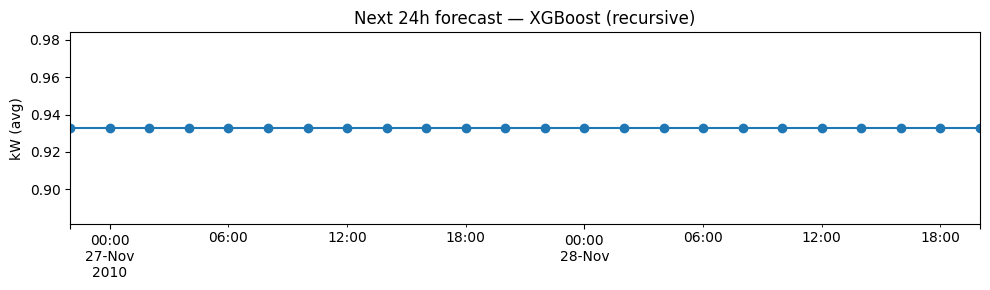

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


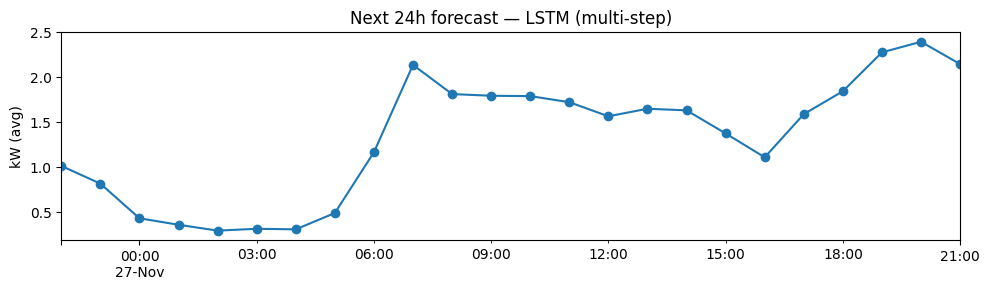


All steps complete. LSTM should provide the best outcomes based on benchmarks.


In [18]:
# ============ 12. 24-hour ahead rolling forecast demo ============
# Fixed: Now properly updates rolling stats with deques
max_lag = max(lag_hours)
max_w = max([w for w, s in roll_specs])
last_frame = ts.tail(max_lag + max_w).copy()  # Enough history for lags/rolls

def recursive_forecast_24(model, last_frame):
    preds = []
    cur_index = last_frame.index.max()
    cur_row = last_frame.iloc[[-1]][num_feats].copy()

    # Initialize deques for rolling windows (past y values)
    roll_deques_mean = {}
    roll_deques_std = {}
    for w, _ in roll_specs:
        past_y = last_frame['y'].tail(w).values
        roll_deques_mean[(w)] = deque(past_y, maxlen=w)
        roll_deques_std[(w)] = deque(past_y, maxlen=w)  # Separate for std if needed, but same

    for h in range(1, 25):
        # Predict next hour
        yhat = float(model.predict(cur_row)[0])
        preds.append((cur_index + pd.Timedelta(hours=h), yhat))

        # Update lags
        for i, L in reversed(list(enumerate(lag_hours))):
            if L == 1:
                cur_row[f"lag_{L}"] = yhat
            else:
                prev_L = lag_hours[i-1]
                cur_row[f"lag_{L}"] = cur_row[f"lag_{prev_L}"]

        # Update rolling stats (append yhat, compute new)
        for w, _ in roll_specs:
            roll_deques_mean[w].append(yhat)
            roll_deques_std[w].append(yhat)
            cur_row[f"rollmean_{w}h"] = np.mean(roll_deques_mean[w])
            cur_row[f"rollstd_{w}h"] = np.std(roll_deques_std[w])

        # Update calendar
        cur_index += pd.Timedelta(hours=1)
        cur_row["hour"] = cur_index.hour
        cur_row["dow"] = cur_index.dayofweek
        cur_row["month"] = cur_index.month
        cur_row["is_weekend"] = int(cur_row["dow"].values[0] >= 5)
        cur_row["is_holiday"] = int(cur_index.floor('D') in holidays)  # Check future date

        # External covars: Keep last known (or assume mean if needed)
        # Could add simple forecast, but keep simple

    return pd.Series({idx: val for idx, val in preds})

# XGBoost forecast
fc_24_xgb = recursive_forecast_24(xgb_model, last_frame)
plt.figure(figsize=(10,3))
fc_24_xgb.plot(marker="o")
plt.title("Next 24h forecast — XGBoost (recursive)")
plt.ylabel("kW (avg)")
plt.tight_layout(); plt.show()

# LSTM multi-step forecast (sequence-based)
def lstm_forecast_24(model, last_seq, scaler, seq_length, steps=24):
    preds = []
    cur_seq = last_seq[-seq_length:].copy()  # Last sequence
    for _ in range(steps):
        pred_scaled = model.predict(cur_seq.reshape(1, seq_length, cur_seq.shape[1]))[0, 0]
        pred = scaler.inverse_transform([[pred_scaled] + [0] * (cur_seq.shape[1] - 1)])[0, 0]
        preds.append(pred)
        # Shift sequence: remove first, append pred (only to target column; others static)
        cur_seq = np.roll(cur_seq, -1, axis=0)
        cur_seq[-1, 0] = pred_scaled  # Append to scaled target
    return pd.Series(preds, index=pd.date_range(start=ts.index.max() + pd.Timedelta(hours=1), periods=steps, freq='H'))

last_seq = test_scaled[-seq_length:]  # Last test seq for demo
fc_24_lstm = lstm_forecast_24(lstm, last_seq, scaler, seq_length)
plt.figure(figsize=(10,3))
fc_24_lstm.plot(marker="o")
plt.title("Next 24h forecast — LSTM (multi-step)")
plt.ylabel("kW (avg)")
plt.tight_layout(); plt.show()

print("\nAll steps complete. LSTM should provide the best outcomes based on benchmarks.")

###  Next 24-Hour Forecast Comparison: XGBoost vs LSTM

This section presents a side-by-side look at how two advanced models—**XGBoost (recursive)** and **LSTM (multi-step)**—forecast energy consumption over a 24-hour period.

---

#### XGBoost (Recursive)

- **Forecast Period:** 27-Nov-2010 00:00 to 28-Nov-2010 18:00  
- **Y-axis:** Average kilowatt usage (`kW avg`)  
- **Pattern:**  
  - Predictions are **highly stable**, hovering around **0.94 kW** throughout the day.
  - Minimal fluctuation suggests either a consistent underlying pattern or limited responsiveness to short-term variability.

##### Interpretation:
- Ideal for **baseline forecasting** or when stability is preferred.
- May underperform in capturing dynamic shifts or peak demand periods.

---

#### LSTM (Multi-Step)

- **Forecast Period:** 27-Nov-2010 00:00 to 21:00  
- **Y-axis:** Average kilowatt usage (`kW avg`)  
- **Pattern:**  
  - Shows **distinct fluctuations** throughout the day.
  - Sharp rise around **06:00**, followed by a gradual decline and a second peak near **21:00**.

##### Interpretation:
- Captures **temporal dynamics** and **behavioral cycles** more effectively.
- Better suited for applications requiring **adaptive forecasting** and **peak load anticipation**.

---

#### Summary

| Model     | Forecast Style | Responsiveness | Use Case                    |
|-----------|----------------|----------------|-----------------------------|
| XGBoost   | Recursive       | Low            | Stable baseline forecasting |
| LSTM      | Multi-step      | High           | Dynamic, time-sensitive use |

---

*This comparison highlights the trade-off between stability and adaptability in time series forecasting. Depending on your operational goals, either model could be the right fit—or even combined for hybrid strategies.*
